<a href="https://colab.research.google.com/github/Jackkerrison/Jack_lob/blob/main/Running.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Section 1: Environment Setup and Imports
# Install necessary packages
%pip install arch --upgrade
%pip install pathos
!pip install bintrees
%pip install yfinance
%pip install sortedcontainers

# Import necessary modules
import sys
import logging
import psutil
from pathos.multiprocessing import ProcessingPool as Pool
import numpy as np
import pandas as pd
from collections import deque
import time
from sortedcontainers import SortedDict
import random
from arch import arch_model
from io import StringIO
import threading
import tracemalloc
import gc
import yfinance as yf
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import seaborn as sns

# Adjust the CPU monitoring logic
MAX_CPU_PERCENT = 95  # Allow higher CPU usage before pausing
MAX_MEMORY_PERCENT = 90  # Allow higher memory usage
CHECK_INTERVAL = 5  # Check every 5 seconds

def monitor_resources():
    while True:
        cpu_percent = psutil.cpu_percent(interval=1)
        memory_percent = psutil.virtual_memory().percent

        if cpu_percent > MAX_CPU_PERCENT:
            logging.warning(f"High CPU usage: {cpu_percent}%. Pausing execution.")
            time.sleep(1)  # Shorter pause

        if memory_percent > MAX_MEMORY_PERCENT:
            logging.warning(f"High Memory usage: {memory_percent}%. Collecting garbage.")
            gc.collect()
            time.sleep(1)  # Shorter pause

        time.sleep(CHECK_INTERVAL)

# Start monitoring system resources in a separate thread
monitor_thread = threading.Thread(target=monitor_resources, daemon=True)
monitor_thread.start()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for bintrees
  Running setup.py clean for bintrees
Failed to build bintrees
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (bintrees)


Dropped 0 rows due to missing data. (0.00% of the data)
Preview of the fetched data:
                           Open        High         Low       Close  \
Datetime                                                              
2023-05-01 09:30:00  306.970001  308.600006  306.170013  306.315002   
2023-05-01 10:30:00  306.299988  307.552704  305.769989  306.299988   
2023-05-01 11:30:00  306.329987  307.459991  306.100006  307.100006   
2023-05-01 12:30:00  307.100006  308.049988  307.100006  307.584991   
2023-05-01 13:30:00  307.619995  307.980011  306.399994  306.549988   

                      Adj Close   Volume  
Datetime                                  
2023-05-01 09:30:00  306.315002  4971460  
2023-05-01 10:30:00  306.299988  3529718  
2023-05-01 11:30:00  307.100006  1811533  
2023-05-01 12:30:00  307.584991  1998664  
2023-05-01 13:30:00  306.549988  1522938  


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


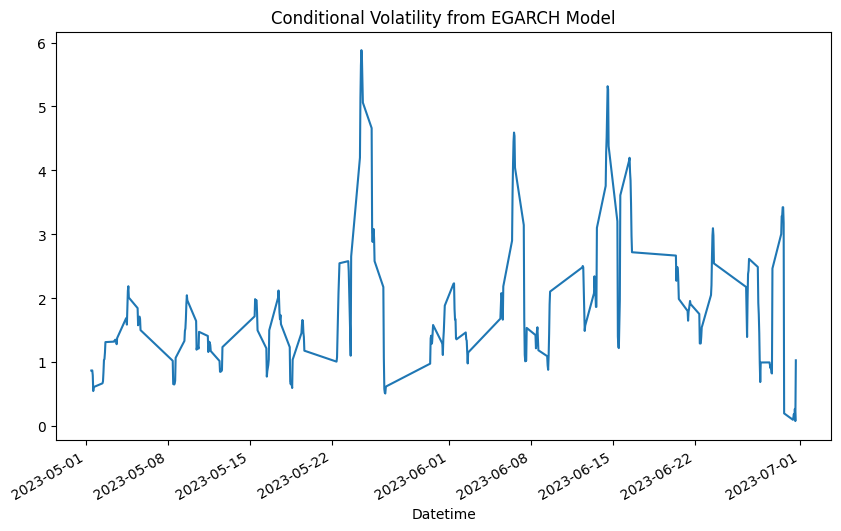

Sample Adjusted Volumes and Liquidity:
                     Adjusted_Volume      Liquidity
Datetime                                           
2023-05-01 09:30:00    835623.030847  781419.395218
2023-05-01 10:30:00    565834.008400  532513.869398
2023-05-01 11:30:00    286592.438090  319862.864039
2023-05-01 12:30:00    265098.710599  195310.144143
2023-05-01 13:30:00    314273.294244  251525.652944
Sample Bid Prices at different levels:
                     Bid_Price_1  Bid_Price_2  Bid_Price_3  Bid_Price_4  \
Datetime                                                                  
2023-05-01 09:30:00       312.38       312.36       312.33       312.30   
2023-05-01 10:30:00       312.39       312.37       312.35       312.33   
2023-05-01 11:30:00       313.22       313.21       313.19       313.18   
2023-05-01 12:30:00       313.73       313.72       313.71       313.71   
2023-05-01 13:30:00       312.66       312.65       312.64       312.64   

                     Bid_Price_5

In [2]:
# Data Fetching and Preparation
try:
    # Fetch MSFT data for the specified date range
    msft_data = yf.download('MSFT', start='2023-05-01', end='2023-07-01', interval='60m', progress=False)
    initial_rows = msft_data.shape[0]

    # Handle missing data for 'Adj Close' and 'Volume'
    if msft_data.isnull().sum().sum() > 0:
        msft_data['Adj Close'] = msft_data['Adj Close'].fillna(method='ffill').fillna(method='bfill')
        msft_data['Volume'] = msft_data['Volume'].fillna(msft_data['Volume'].rolling(window=5, min_periods=1).mean())

    dropped_rows = initial_rows - msft_data.shape[0]
    print(f"Dropped {dropped_rows} rows due to missing data. ({(dropped_rows / initial_rows) * 100:.2f}% of the data)")
    print("Preview of the fetched data:")
    print(msft_data.head())

except Exception as e:
    print(f"Error fetching data: {e}")

# Rolling window for volatility calculation
rolling_window = 10
initial_volatility = msft_data['Adj Close'].rolling(window=rolling_window).std().dropna()

# Calculate Returns and GARCH Model Fitting
try:
    returns = msft_data['Adj Close'].pct_change().dropna()
    egarch_fitted = arch_model(returns * 100, vol='EGarch', p=1, q=1, o=1, dist='t').fit(disp='off')
    volatility = (egarch_fitted.conditional_volatility / 100).round(2)

    # Smooth transition of volatility
    if not initial_volatility.empty:
        volatility.iloc[:len(initial_volatility)] = initial_volatility.values
    # Plot the conditional volatility
    volatility.plot(title='Conditional Volatility from EGARCH Model', figsize=(10, 6))
    plt.show()

except Exception as e:
    print(f"Error in GARCH model fitting: {e}")

# Adjusted liquidity calculation
def time_weighted_liquidity(volume, timestamp):
    typical_liquidity_factor = np.random.uniform(0.7, 1.2)  # Tighter liquidity bounds
    if timestamp.hour < 10:
        return volume * typical_liquidity_factor * np.random.uniform(1.1, 1.4)  # Early morning liquidity bump
    elif timestamp.hour >= 15:
        return volume * typical_liquidity_factor * np.random.uniform(1.2, 1.5)  # Higher liquidity at close
    else:
        return volume * typical_liquidity_factor * np.random.uniform(0.8, 1.1)  # Lower liquidity midday

# Correct dynamic liquidity adjustment function without 'self'
def dynamic_liquidity(volume, executed_order_size, base_liquidity):
    remaining_liquidity = base_liquidity - (executed_order_size * 0.15)  # Higher reduction for large orders
    return max(remaining_liquidity, volume * 0.3)  # Ensure liquidity doesn't fall below a threshold

# Align Data
aligned_data = pd.concat([msft_data['Adj Close'], msft_data['Volume'], volatility, msft_data['High'], msft_data['Low']], axis=1).ffill().bfill()
aligned_data.columns = ['Adj Close', 'Volume', 'Volatility', 'High', 'Low']

# Adjusted volume calculation based on realistic values
volume_multiplier = np.random.uniform(0.7, 1.3, len(aligned_data))  # More realistic range
typical_daily_volume = 20000000  # MSFT typical daily volume
hourly_volume = typical_daily_volume / 7  # Assuming 7 hours of trading in a day
aligned_data['Adjusted_Volume'] = (aligned_data['Volume'] / aligned_data['Volume'].max()) * hourly_volume * volume_multiplier

# Adjusted volume calculation based on realistic values
volume_multiplier = np.random.uniform(0.7, 1.3, len(aligned_data))  # More realistic range
typical_daily_volume = 20000000  # MSFT typical daily volume
hourly_volume = typical_daily_volume / 7  # Assuming 7 hours of trading in a day
aligned_data['Adjusted_Volume'] = (aligned_data['Volume'] / aligned_data['Volume'].max()) * hourly_volume * volume_multiplier

# Initial Liquidity Calculation
aligned_data['Liquidity'] = aligned_data.apply(lambda row: time_weighted_liquidity(row['Adjusted_Volume'], row.name), axis=1)

# Now apply dynamic liquidity adjustment after creating the initial Liquidity column
aligned_data['Liquidity'] = aligned_data.apply(lambda row: dynamic_liquidity(row['Adjusted_Volume'], 100000, row['Liquidity']), axis=1)

# Print volume and liquidity for verification
print("Sample Adjusted Volumes and Liquidity:")
print(aligned_data[['Adjusted_Volume', 'Liquidity']].head())

# Recalibrating spread to reflect MSFT’s tight bid-ask spreads
def dynamic_spread(adj_close, volatility, liquidity, base_spread_factor=0.0001, volatility_multiplier=0.2):
    base_spread = adj_close * base_spread_factor * (1 + volatility * volatility_multiplier)
    liquidity_adjustment = 1 + np.random.uniform(0.01, 0.02)  # Narrower spread fluctuation
    spread = base_spread * liquidity_adjustment
    return np.clip(spread, adj_close * 0.0001, adj_close * 0.0004).round(4)  # Tighter spread range

# Apply the updated spread calculation
aligned_data['Spread'] = aligned_data.apply(
    lambda row: dynamic_spread(row['Adj Close'], row['Volatility'], row['Liquidity']), axis=1)

def market_response(price, order_size, daily_volume, liquidity, volatility, market_conditions='stable'):
    # Increase price response for large orders and during volatile market conditions
    market_impact_factor = np.random.uniform(0.01, 0.05) if market_conditions == 'volatile' else np.random.uniform(0.005, 0.015)
    impact = price * (1 + market_impact_factor * (order_size / liquidity))  # Increased sensitivity based on liquidity
    return np.clip(impact, price * 0.98, price * 1.02).round(2)

# Use this function in VWAP and TWAP executions
aligned_data['Mid_Price'] = aligned_data.apply(lambda row: market_response(row['Adj Close'], row['Volume'], 20000000, row['Liquidity'], row['Volatility'], 'stable'), axis=1)

# VWAP Calculation
def calculate_vwap(prices, volumes):
    cumulative_price_volume = np.cumsum(prices * volumes)
    cumulative_volume = np.cumsum(volumes)
    vwap = cumulative_price_volume / cumulative_volume
    return vwap.round(2)

aligned_data['VWAP'] = calculate_vwap(aligned_data['Adj Close'], aligned_data['Volume'])

# Calculate Typical Price and TWAP
aligned_data['Typical Price'] = ((aligned_data['Adj Close'] + aligned_data['High'] + aligned_data['Low']) / 3).round(2)

# Refined TWAP Calculation using exponentially weighted moving average (EWMA)
def calculate_twap(prices, alpha=0.05):
    # Further reduce alpha for a smoother TWAP
    return prices.ewm(alpha=alpha, adjust=False).mean().round(2)

aligned_data['TWAP'] = calculate_twap(aligned_data['Typical Price'])

# Generate bid/ask prices for different levels
num_levels = 10
level_multipliers = np.exp(-np.arange(num_levels) / 2)  # Steeper decay for higher levels

# Distribute bid/ask liquidity across levels with realistic differences
def distribute_liquidity_across_levels(mid_price, liquidity, num_levels=10):
    level_multipliers = np.exp(-np.arange(num_levels) / 2)  # Steeper decay for higher levels
    total_liquidity = liquidity * level_multipliers / level_multipliers.sum()
    return total_liquidity

# Modify bid/ask prices with more variability and progressive spreads
level_variability = np.random.uniform(0.995, 1.010, size=(len(aligned_data), num_levels))

# Adjust bid/ask prices using increasing spread for each level with a larger step change
bid_prices = np.zeros((len(aligned_data), num_levels))
ask_prices = np.zeros((len(aligned_data), num_levels))

# Larger step for spread modification at each level, incorporating liquidity sensitivity
for i in range(num_levels):
    # Increase spread significantly for deeper levels
    spread_multiplier = 1 + i * 0.5  # Adjust this factor to increase/decrease spread growth
    liquidity_impact = aligned_data['Liquidity'].values / aligned_data['Liquidity'].mean()  # Adjust based on liquidity

    bid_prices[:, i] = aligned_data['Mid_Price'].values - (aligned_data['Spread'].values * spread_multiplier * liquidity_impact) * level_variability[:, i]
    ask_prices[:, i] = aligned_data['Mid_Price'].values + (aligned_data['Spread'].values * spread_multiplier * liquidity_impact) * level_variability[:, i]

# Round the prices
bid_prices = np.round(bid_prices, 2)
ask_prices = np.round(ask_prices, 2)

# Store bid/ask prices in DataFrames
df_bid_prices = pd.DataFrame(bid_prices, index=aligned_data.index, columns=[f'Bid_Price_{i+1}' for i in range(num_levels)])
df_ask_prices = pd.DataFrame(ask_prices, index=aligned_data.index, columns=[f'Ask_Price_{i+1}' for i in range(num_levels)])

# Combine the bid/ask price levels back into aligned_data
aligned_data = pd.concat([aligned_data, df_bid_prices, df_ask_prices], axis=1)

# Print bid and ask prices for verification
print("Sample Bid Prices at different levels:")
print(df_bid_prices.head())
print("Sample Ask Prices at different levels:")
print(df_ask_prices.head())

# Display order book summary with adjusted format
pd.options.display.float_format = '{:.2f}'.format
print("Order book summary:\n", aligned_data.describe().transpose())

<ipython-input-3-6e89065718ed>:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aligned_data['Order_Imbalance'] = (bid_volumes - ask_volumes).rolling(window=5).mean().fillna(method='bfill')
<ipython-input-3-6e89065718ed>:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[4, 0].set_xticklabels(axes[4, 0].get_xticklabels(), rotation=45)
<ipython-input-3-6e89065718ed>:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


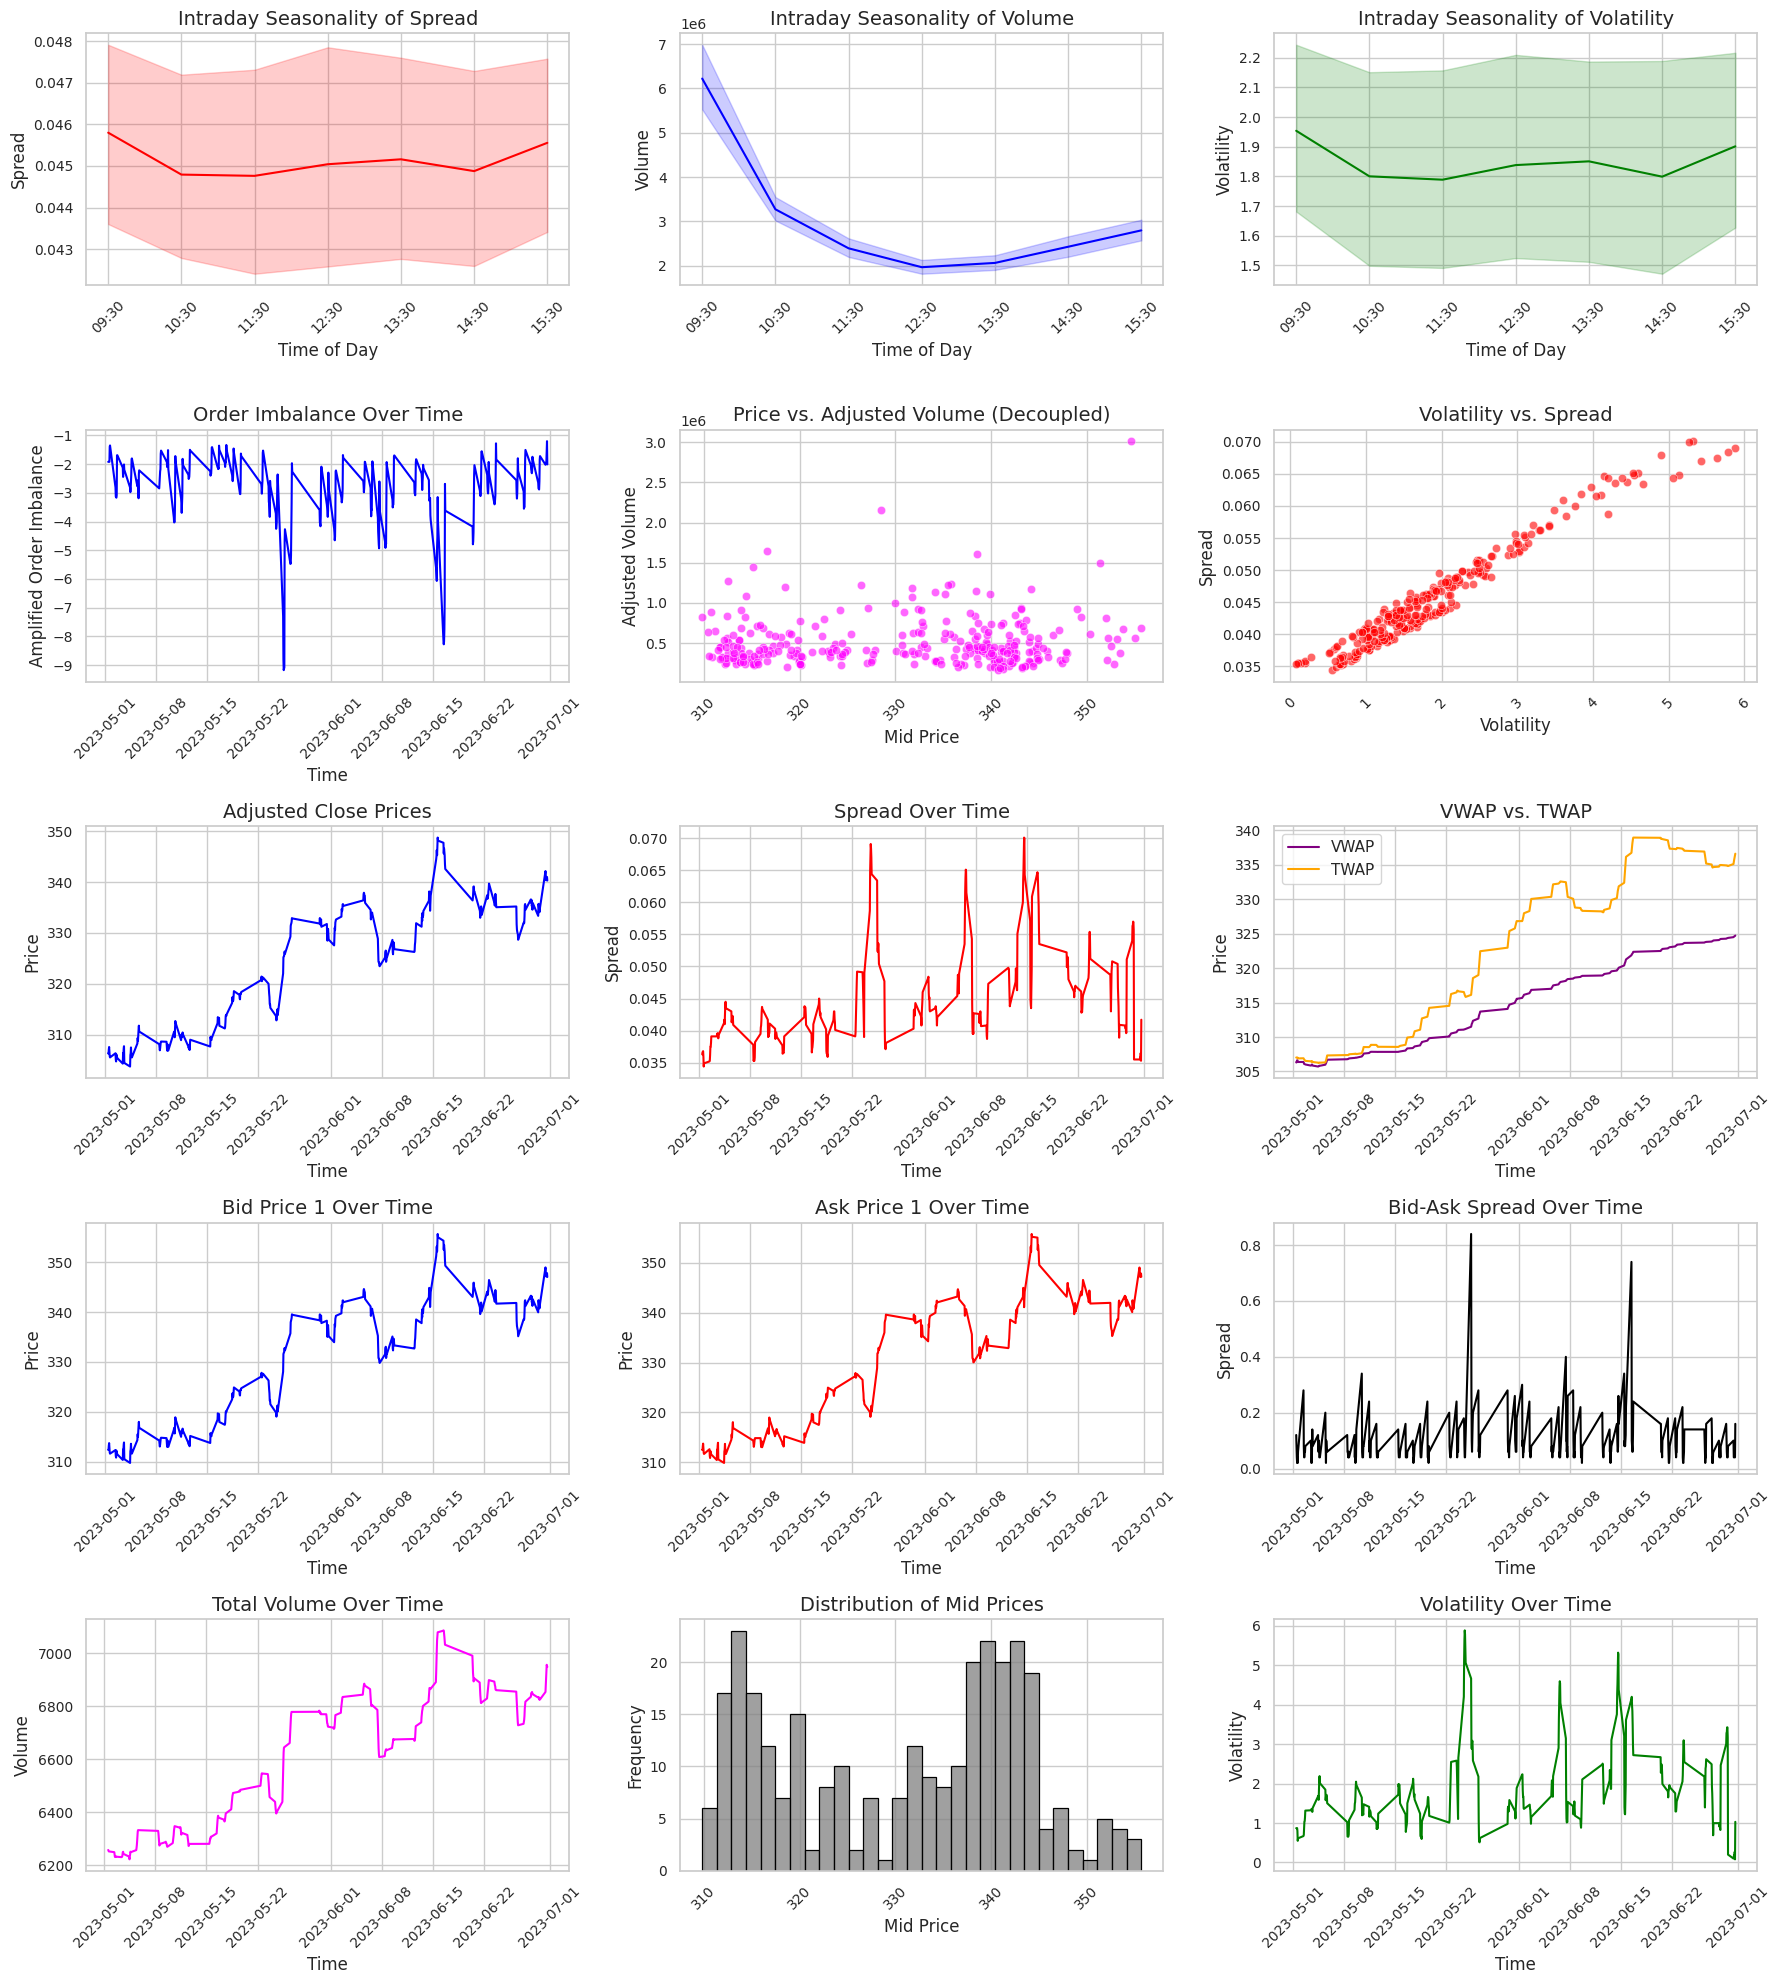

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the index is a datetime object
aligned_data.index = pd.to_datetime(aligned_data.index)

# Grouping the data by time-of-day to observe intraday patterns
aligned_data['Time_of_Day'] = aligned_data.index.time

# Convert Time_of_Day to a string representation of time (HH:MM)
aligned_data['Time_of_Day'] = aligned_data['Time_of_Day'].apply(lambda x: x.strftime('%H:%M'))

# Set the style and palette for the plots
sns.set(style="whitegrid")
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Create a figure with multiple subplots
fig, axes = plt.subplots(5, 3, figsize=(18, 20))  # Adjusted to fit 15 plots (5 rows, 3 columns)

# 1. Spread over the day
sns.lineplot(x='Time_of_Day', y='Spread', data=aligned_data, ax=axes[0, 0], color='red')
axes[0, 0].set_title('Intraday Seasonality of Spread')
axes[0, 0].set_xlabel('Time of Day')
axes[0, 0].set_ylabel('Spread')

# 2. Volume over the day
sns.lineplot(x='Time_of_Day', y='Volume', data=aligned_data, ax=axes[0, 1], color='blue')
axes[0, 1].set_title('Intraday Seasonality of Volume')
axes[0, 1].set_xlabel('Time of Day')
axes[0, 1].set_ylabel('Volume')

# 3. Volatility over the day
sns.lineplot(x='Time_of_Day', y='Volatility', data=aligned_data, ax=axes[0, 2], color='green')
axes[0, 2].set_title('Intraday Seasonality of Volatility')
axes[0, 2].set_xlabel('Time of Day')
axes[0, 2].set_ylabel('Volatility')

# Order Imbalance Calculation
bid_volumes = aligned_data[[f'Bid_Price_{i+1}' for i in range(10)]].sum(axis=1)
ask_volumes = aligned_data[[f'Ask_Price_{i+1}' for i in range(10)]].sum(axis=1)
# Apply smoothing and clipping to the order imbalance calculation
aligned_data['Order_Imbalance'] = (bid_volumes - ask_volumes).rolling(window=5).mean().fillna(method='bfill')
aligned_data['Order_Imbalance'] = aligned_data['Order_Imbalance'].clip(lower=-5000, upper=5000)
sns.lineplot(x=aligned_data.index, y=aligned_data['Order_Imbalance'], ax=axes[1, 0], color='blue')
axes[1, 0].set_title('Order Imbalance Over Time')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Amplified Order Imbalance')

# 5. Price vs Adjusted Volume (Decoupled)
sns.scatterplot(x=aligned_data['Mid_Price'], y=aligned_data['Adjusted_Volume'], ax=axes[1, 1], color='magenta', alpha=0.6)
axes[1, 1].set_title('Price vs. Adjusted Volume (Decoupled)')
axes[1, 1].set_xlabel('Mid Price')
axes[1, 1].set_ylabel('Adjusted Volume')

# 6. Volatility vs Spread Scatter Plot
sns.scatterplot(x=aligned_data['Volatility'], y=aligned_data['Spread'], ax=axes[1, 2], color='red', alpha=0.6)
axes[1, 2].set_title('Volatility vs. Spread')
axes[1, 2].set_xlabel('Volatility')
axes[1, 2].set_ylabel('Spread')

# 7. Adjusted Close Prices Over Time
sns.lineplot(x=aligned_data.index, y='Adj Close', data=aligned_data, ax=axes[2, 0], color='blue')
axes[2, 0].set_title('Adjusted Close Prices')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('Price')

# 8. Spread Over Time
sns.lineplot(x=aligned_data.index, y='Spread', data=aligned_data, ax=axes[2, 1], color='red')
axes[2, 1].set_title('Spread Over Time')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Spread')

# 9. VWAP vs TWAP
sns.lineplot(x=aligned_data.index, y='VWAP', data=aligned_data, ax=axes[2, 2], color='purple', label='VWAP')
sns.lineplot(x=aligned_data.index, y='TWAP', data=aligned_data, ax=axes[2, 2], color='orange', label='TWAP')
axes[2, 2].set_title('VWAP vs. TWAP')
axes[2, 2].set_xlabel('Time')
axes[2, 2].set_ylabel('Price')
axes[2, 2].legend()

# 10. Bid Price 1 Over Time
sns.lineplot(x=aligned_data.index, y='Bid_Price_1', data=aligned_data, ax=axes[3, 0], color='blue')
axes[3, 0].set_title('Bid Price 1 Over Time')
axes[3, 0].set_xlabel('Time')
axes[3, 0].set_ylabel('Price')

# 11. Ask Price 1 Over Time
sns.lineplot(x=aligned_data.index, y='Ask_Price_1', data=aligned_data, ax=axes[3, 1], color='red')
axes[3, 1].set_title('Ask Price 1 Over Time')
axes[3, 1].set_xlabel('Time')
axes[3, 1].set_ylabel('Price')

# 12. Bid-Ask Spread Over Time
bid_ask_spread = aligned_data['Ask_Price_1'] - aligned_data['Bid_Price_1']
sns.lineplot(x=aligned_data.index, y=bid_ask_spread, ax=axes[3, 2], color='black')
axes[3, 2].set_title('Bid-Ask Spread Over Time')
axes[3, 2].set_xlabel('Time')
axes[3, 2].set_ylabel('Spread')

# 13. Total Volume (Bid + Ask) Over Time
# Calculate Total Volume (Bid + Ask)
aligned_data['Total_Volume'] = aligned_data[[f'Bid_Price_{i+1}' for i in range(10)]].sum(axis=1) + aligned_data[[f'Ask_Price_{i+1}' for i in range(10)]].sum(axis=1)
aligned_data['Smoothed_Total_Volume'] = aligned_data['Total_Volume'].rolling(window=5).mean()
sns.lineplot(x=aligned_data.index, y=aligned_data['Smoothed_Total_Volume'], ax=axes[4, 0], color='magenta')
axes[4, 0].set_xticklabels(axes[4, 0].get_xticklabels(), rotation=45)
axes[4, 0].set_title('Total Volume Over Time')
axes[4, 0].set_xlabel('Time')
axes[4, 0].set_ylabel('Volume')

# 14. Distribution of Mid Prices
sns.histplot(aligned_data['Mid_Price'], bins=30, kde=False, color='grey', ax=axes[4, 1], edgecolor='black')
axes[4, 1].set_title('Distribution of Mid Prices')
axes[4, 1].set_xlabel('Mid Price')
axes[4, 1].set_ylabel('Frequency')

# 15. Volatility Over Time
sns.lineplot(x=aligned_data.index, y='Volatility', data=aligned_data, ax=axes[4, 2], color='green')
axes[4, 2].set_title('Volatility Over Time')
axes[4, 2].set_xlabel('Time')
axes[4, 2].set_ylabel('Volatility')

# Rotating x-axis labels for all subplots that require it
for ax in axes.flat:  # This iterates through each subplot in the figure
    if len(ax.get_xticklabels()) > 0:  # Check if the subplot has x-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust layout and show all plots
plt.tight_layout()
plt.show()

In [4]:
class Order:
    def __init__(self, price, quantity, tid):
        self.price = round(price, 2)  # Ensure prices are rounded to 2 decimal places
        self.quantity = quantity
        self.tid = tid

class OrderBook:
    def __init__(self, transaction_cost=0.001):
        self.bids = SortedDict(lambda x: -x)  # Sorted descending
        self.asks = SortedDict()  # Sorted ascending
        self.trades = []
        self.transaction_cost = transaction_cost
        self.liquidity_fluctuation_factor = 0.1
        self.external_order_probability = 0.2
        self.mean_reversion_strength = 0.1

        # Initialize the order book with market maker orders and simulate continuous order flow
        self.reset_order_book()

    def reset_order_book(self):
        self.mid_price = 335  # You may set this to any realistic initial value or calculate it dynamically
        self._generate_market_maker_orders()  # Generate the initial market maker orders
        #self._simulate_continuous_order_flow()  # Start the continuous order flow simulation

    # Keep this function inside the OrderBook class
    def _calculate_slippage(self, executed_qty, liquidity, market_conditions='stable'):
        # Increase slippage for larger trades
        base_slippage = 0.01 if market_conditions == 'volatile' else 0.005
        slippage = base_slippage * np.log(1 + (executed_qty / liquidity))
        return slippage

    def _process_market_order(self, order):
        opposite_side = self.asks if order['side'] == 'bid' else self.bids
        remaining_qty = order['qty']
        total_cost = 0
        executed_volume = 0
        slippage_total = 0  # Initialize slippage total

        if not opposite_side:
            print("No available liquidity on the opposite side.")
            return 0, 0, 0, 0  # Early exit if no liquidity

        initial_price = next(iter(opposite_side))

        print(f"Processing market order: {order['qty']} shares on side {order['side']} at target price {initial_price}.")

        while remaining_qty > 0 and opposite_side:
            best_price = next(iter(opposite_side))
            best_order = opposite_side[best_price][0]
            trade_qty = min(best_order.quantity, remaining_qty)
            liquidity = sum(order.quantity for order in opposite_side[best_price])

            # Calculate slippage dynamically based on trade size, liquidity, and market conditions
            slippage = self._calculate_slippage(trade_qty, liquidity, 'volatile')  # Correctly call slippage with 'self'
            slippage_total += slippage * trade_qty  # Accumulate total slippage

            # Adjust the executed price based on slippage
            executed_price = round(best_price * (1 + slippage), 2)

            print(f"Matching order: Price {best_price}, Qty {trade_qty}, Executed price: {executed_price}, Liquidity: {liquidity}")

            # Append trade to trade history
            self.trades.append({'price': executed_price, 'qty': trade_qty})
            remaining_qty -= trade_qty
            best_order.quantity -= trade_qty
            executed_volume += trade_qty  # Accumulate executed volume
            total_cost += trade_qty * executed_price  # Accumulate total cost

            # Remove the best order if fully filled
            if best_order.quantity == 0:
                opposite_side[best_price].popleft()
                if not opposite_side[best_price]:
                    del opposite_side[best_price]

            # Stop if no more orders are available on the opposite side
            if not opposite_side:
                break

        # Calculate average price and other metrics
        avg_price = round(total_cost / executed_volume, 2) if executed_volume > 0 else 0
        market_impact = max(0.001, np.random.uniform(0.001, 0.005) * (executed_volume / liquidity) * (1 + slippage))
        slippage_percentage = max(0.0001, np.random.uniform(0.0001, 0.001) * (executed_volume / liquidity))  # Correct slippage with executed_volume

        return executed_volume, avg_price, slippage_percentage, market_impact

    # Replace the previous order book generation method with this
    def _generate_market_maker_orders(self):
        spread = 0.25
        liquidity_range = (1000, 5000)
        for i in range(15):
            bid_price = self.mid_price - i * spread
            ask_price = self.mid_price + i * spread
            self.bids[bid_price] = deque([Order(bid_price, np.random.randint(*liquidity_range), f'bid-{i}')])
            self.asks[ask_price] = deque([Order(ask_price, np.random.randint(*liquidity_range), f'ask-{i}')])

    def calculate_vwap(self, trades):
        if not trades:
            return 0
        prices = np.array([trade['price'] for trade in trades])
        quantities = np.array([trade['qty'] for trade in trades])
        cumulative_price_volume = np.cumsum(prices * quantities)
        cumulative_volume = np.cumsum(quantities)
        vwap = cumulative_price_volume / cumulative_volume
        vwap_value = round(vwap[-1], 2)

        # Add logging
        print(f"VWAP Calculation: {vwap_value}, based on {len(trades)} trades.")

        return vwap_value

    def calculate_twap(self, trades):
        if not trades:
            return 0
        times = np.linspace(1, len(trades), len(trades))  # Time intervals, starting from 1
        weighted_prices = [trade['price'] for trade in trades]

        # Ensure no division by zero occurs if weights (times) are all zero
        if np.sum(times) == 0:
            return 0
        twap = np.average(weighted_prices, weights=times)
        twap_value = round(twap, 2)

        # Add logging
        print(f"TWAP Calculation: {twap_value}, based on {len(trades)} trades.")

        return twap_value

    def process_order(self, order):
        # Introduce randomness to simulate other market participants
        if np.random.rand() < self.external_order_probability:
            self._generate_external_order()

        if order['type'] == 'limit':
            self._process_limit_order(order)
        elif order['type'] == 'market':
            # Process the market order
            executed_volume, avg_price, slippage_percentage, market_impact = self._process_market_order(order)

            # Calculate VWAP and TWAP after processing the order
            vwap_value = self.calculate_vwap(self.trades)
            twap_value = self.calculate_twap(self.trades)

            # Add detailed logging of the execution
            total_order_qty = order['qty']
            remaining_qty = total_order_qty - executed_volume

            # Log the execution details with remaining quantity
            print(f"Order: {total_order_qty} shares; Executed: {executed_volume}, Remaining: {remaining_qty}")
            print(f"Average Price: {avg_price:.2f}, Slippage: {slippage_percentage:.2f}%, Market Impact: {market_impact:.4f}")
            print(f"VWAP: {vwap_value}, TWAP: {twap_value}")
        else:
            print(f"Unknown order type: {order['type']}")

    def _process_limit_order(self, order):
        side = self.bids if order['side'] == 'bid' else self.asks
        opposite = self.asks if order['side'] == 'bid' else self.bids
        price = round(order['price'], 2)  # Ensure prices are rounded
        qty = order['qty']

        # Add a print statement at the start of limit order processing for visibility
        print(f"Processing limit order: {qty} shares on side {order['side']} at price {price}.")

        # Attempt to match against opposite orders
        while qty > 0 and opposite:
            best_price = opposite.peekitem(0)[0]  # Get the best price from the opposite side

            if (order['side'] == 'bid' and price >= best_price) or (order['side'] == 'ask' and price <= best_price):
                best_orders = opposite[best_price]  # Get the best orders at the best price
                while qty > 0 and best_orders:
                    best_order = best_orders[0]
                    trade_qty = min(qty, best_order.quantity)  # Determine the trade quantity
                    executed_price = round(best_price * (1 + self.transaction_cost * (-1 if order['side'] == 'bid' else 1)), 2)  # Adjust price with transaction cost

                    # Append trade details to the trade history
                    self.trades.append({'price': executed_price, 'qty': trade_qty})
                    qty -= trade_qty  # Reduce the remaining quantity to be matched
                    best_order.quantity -= trade_qty  # Reduce the quantity of the matched order

                    # Log executed and remaining quantities
                    print(f"Order: {order['qty']} shares; Executed: {order['qty'] - qty}, Remaining: {qty}")

                    # Remove the order if fully executed
                    if best_order.quantity == 0:
                        best_orders.popleft()
                    if not best_orders:
                        del opposite[best_price]
            else:
                break  # Exit the loop if no more matching is possible

        # Add the remaining quantity to the book if it's not fully matched
        if qty > 0:
            if price in side:
                side[price].append(Order(price, qty, order['tid']))
            else:
                side[price] = deque([Order(price, qty, order['tid'])])

    def _fluctuate_liquidity(self, side):
        # Apply random adjustments to the remaining liquidity in the order book
        for price, orders in list(side.items()):
            for order in orders:
                # Adjust the quantity slightly to simulate changing liquidity
                fluctuation_factor = np.random.uniform(0.8, 1.2)  # Small random variation in liquidity
                order.quantity = max(1, int(order.quantity * fluctuation_factor))  # Ensure the quantity is at least 1

        # Optionally, you could remove prices with extremely low liquidity
        for price in list(side.keys()):
            if sum(order.quantity for order in side[price]) <= 1:  # If liquidity is very low, remove the price level
                del side[price]

    def _generate_external_order(self):
        side = 'bid' if np.random.rand() > 0.5 else 'ask'
        price = self._get_random_price(side)
        qty = np.random.randint(500, 2000)  # Larger random orders
        order = {
            'type': 'limit',
            'side': side,
            'price': price,
            'qty': qty,
            'tid': 'external'
        }
        self.process_order(order)

    # Add this new function within the OrderBook class
    def _generate_incoming_order(self):
        side = 'bid' if np.random.rand() > 0.5 else 'ask'
        price = self._get_random_price(side)
        qty = np.random.randint(500, 2000)
        order_type = np.random.choice(['limit', 'market'])
        order = {
            'type': order_type,
            'side': side,
            'price': price,
            'qty': qty,
            'tid': 'external'
        }
        self.process_order(order)

    def _simulate_continuous_order_flow(self):
        while True:
            if np.random.rand() < self.external_order_probability:
                self._generate_incoming_order()
                self._adjust_liquidity()
            time.sleep(np.random.uniform(0.1, 1.0))  # Adjust the timing to simulate realistic order flow

    def _ensure_residual_liquidity(self, side):
        # Make sure there is a minimum liquidity at each price level
        for price, orders in side.items():
            total_quantity = sum(order.quantity for order in orders)
            if total_quantity < 100:  # Arbitrary threshold for residual liquidity
                orders[-1].quantity += 100  # Ensure at least 100 units remain at each price level

    def _get_mid_price(self):
        return (min(self.asks.keys()) + max(self.bids.keys())) / 2 if self.asks and self.bids else 100.0

    def _initialize_market_maker(self):
        # Generate market maker orders
        self._generate_market_maker_orders()

        # Start simulating continuous order flow
        self._simulate_continuous_order_flow()

    def _simulate_market_impact(self, side, qty_remaining):
        # Apply more aggressive market impact based on trade size
        impact_factor = 0.01  # Higher impact factor for more realistic price adjustments
        for price, orders in list(side.items()):
            adjusted_price = price * (1 + impact_factor * (qty_remaining / sum(order.quantity for order in orders)) ** 2)  # More sensitive impact
            if adjusted_price != price:
                side[round(adjusted_price, 2)] = side.pop(price)

    def _mean_reversion(self):
        for side in [self.bids, self.asks]:
            for price in list(side.keys()):
                reverted_price = price * (1 - self.mean_reversion_strength * 0.5)
                if reverted_price in side:
                    side[reverted_price].extend(side[price])
                else:
                    side[reverted_price] = side[price]
                del side[price]

    def _get_random_price(self, side):
        # Assume realistic prices are around the mid-price range of the data, e.g., 300-350.
        realistic_price_range = (300, 350)

        if side == 'bid' and self.bids:
            return round(max(self.bids.keys()) * np.random.uniform(0.99, 1.01), 2)
        elif side == 'ask' and self.asks:
            return round(min(self.asks.keys()) * np.random.uniform(0.99, 1.01), 2)
        else:
            mid_price = np.random.uniform(*realistic_price_range)
            return round(mid_price * np.random.uniform(0.99, 1.01), 2)

    def _adjust_liquidity(self):
        for price in list(self.bids.keys()):
            for order in self.bids[price]:
                order.quantity = max(200, int(order.quantity * np.random.uniform(0.8, 1.2)))
        for price in list(self.asks.keys()):
            for order in self.asks[price]:
                order.quantity = max(200, int(order.quantity * np.random.uniform(0.8, 1.2)))

    def print_book(self, levels=5):
        print("\nOrder Book Snapshot:")
        print("Asks:")
        for price, orders in list(self.asks.items())[:levels]:
            total_qty = sum(order.quantity for order in orders)
            print(f"Price: {price:.2f}, Quantity: {total_qty}")
        print("Bids:")
        for price, orders in list(self.bids.items())[:levels]:
            total_qty = sum(order.quantity for order in orders)
            print(f"Price: {price:.2f}, Quantity: {total_qty}")

    def print_trades(self):
        print("\nTrades:")
        for trade in self.trades:
            print(f"Traded {trade['qty']} @ {trade['price']:.2f}")

In [5]:
# Function to check the current state of the order book
def check_order_book_state(lob):
    print("[DEBUG] Checking order book state...")

    print("[DEBUG] Bids in the order book (Top 5 Levels):")
    for price, orders in list(lob.bids.items())[:5]:  # Print the top 5 levels of bids
        total_qty = sum(order.quantity for order in orders)
        print(f"Price: {price:.2f}, Total Quantity: {total_qty}")

    print("[DEBUG] Asks in the order book (Top 5 Levels):")
    for price, orders in list(lob.asks.items())[:5]:  # Print the top 5 levels of asks
        total_qty = sum(order.quantity for order in orders)
        print(f"Price: {price:.2f}, Total Quantity: {total_qty}")

# Function to populate order book
def populate_order_book(lob, aligned_data):
    print("\n[DEBUG] Populating the order book with initial data...")

    for index, row in aligned_data.iterrows():
        mid_price = row['Mid_Price']  # Use the calculated mid_price

        # Get the liquidity value from the aligned data
        liquidity = row['Liquidity'] / 10  # Use realistic liquidity

        # Dynamically determine the maximum number of price levels
        max_levels = min(10, len([col for col in row.index if col.startswith('Bid_Price_')]))

        # Loop over only the available levels
        for level in range(1, max_levels + 1):
            bid_order = {
                'type': 'limit',
                'side': 'bid',
                'instrument': 'MSFT',
                'qty': round(liquidity * np.random.uniform(0.8, 1.2)),  # Use liquidity for MSFT
                'price': round(row[f'Bid_Price_{level}'], 2),
                'tid': f"bid-{index}-{level}"
            }
            ask_order = {
                'type': 'limit',
                'side': 'ask',
                'instrument': 'MSFT',
                'qty': round(liquidity * np.random.uniform(0.8, 1.2)),  # Use liquidity for MSFT
                'price': round(row[f'Ask_Price_{level}'], 2),
                'tid': f"ask-{index}-{level}"
            }

            lob.process_order(bid_order)
            lob.process_order(ask_order)

    print("\n[DEBUG] Initial Order Book Snapshot (Top 5 Levels):")
    lob.print_book(levels=5)  # Show the top 5 levels

def execute_vwap_order_with_shares(lob, total_shares):
    executed_volume, total_cost = 0, 0
    transaction_cost_total = 0
    remaining_shares = total_shares
    lob.trades.clear()

    # Lists to store data for plotting
    vwap_prices, vwap_volumes, vwap_slippage, vwap_market_impact = [], [], [], []

    print(f"\n[DEBUG] VWAP function started to buy {total_shares} shares.", flush=True)
    lob.print_book(levels=5)  # Print the top 5 levels of the order book before execution

    while remaining_shares > 0:
        print(f"\n[DEBUG] VWAP loop - remaining shares: {remaining_shares}.", flush=True)
        price_range = sorted([p for p in lob.asks.keys() if p > 0])[:5]

        if not price_range:  # Halt if no valid prices remain
            print(f"[DEBUG] VWAP halted: No valid prices in the order book.", flush=True)
            break

        target_price = np.random.choice(price_range)
        liquidity = sum(order.quantity for order in lob.asks[target_price])

        print(f"\n[DEBUG] VWAP selecting target price: ${target_price:.2f}, liquidity: {liquidity}", flush=True)

        current_order_qty = min(remaining_shares, liquidity)

        if current_order_qty <= 0:
            print(f"[DEBUG] VWAP halted: Insufficient liquidity to buy at price {target_price}.", flush=True)
            break

        print(f"VWAP: Buying {current_order_qty} shares at ${target_price:.2f} per share. Liquidity: {liquidity}.", flush=True)

        market_order = {
            'type': 'market',
            'side': 'bid',
            'instrument': 'MSFT',
            'qty': min(current_order_qty, int(liquidity * 0.3)),  # Now using only 30% of available liquidity
            'tid': -1
        }

        # Process the market order and capture the return values correctly
        exec_vol, avg_price, slippage_percentage, market_impact = lob._process_market_order(market_order)

        # Update total cost, executed volume, and remaining shares
        total_cost += exec_vol * avg_price
        executed_volume += exec_vol
        remaining_shares -= exec_vol
        transaction_cost = exec_vol * avg_price * (lob.transaction_cost * 1.2)
        transaction_cost_total += transaction_cost

        # Append exec_vol to volumes
        vwap_volumes.append(exec_vol)

        # Collect data for plotting
        vwap_prices.append(avg_price)
        vwap_slippage.append(slippage_percentage)
        vwap_market_impact.append(market_impact)

        print(f"VWAP: Executed {exec_vol} shares at avg price {avg_price:.2f}. Remaining shares: {remaining_shares}.", flush=True)
        print(f"VWAP: Slippage: {slippage_percentage:.4f}, Market Impact: {market_impact:.4f}", flush=True)

        vwap_value = lob.calculate_vwap(lob.trades)
        print(f"VWAP value: {vwap_value}", flush=True)

        lob._generate_external_order()  # Simulate market dynamics
        time.sleep(0.3)

    avg_price = round(total_cost / executed_volume, 2) if executed_volume > 0 else 0
    transaction_cost_total = round(transaction_cost_total, 2)

    print(f"\n[DEBUG] VWAP Execution Complete: Executed Volume = {executed_volume}, Avg Price = ${avg_price:.2f}, Total Cost = ${total_cost:.2f}, Remaining Shares = {remaining_shares}", flush=True)

    # Return collected data for plotting
    return {
        'prices': vwap_prices,
        'volumes': vwap_volumes,
        'slippage': vwap_slippage,
        'market_impact': vwap_market_impact,
        'total_cost': total_cost,
        'avg_price': avg_price,
        'transaction_cost_total': transaction_cost_total,
        'volume': executed_volume  # Ensure executed_volume is correctly returned
    }

# Adapt the share distribution to follow intraday volume patterns (higher at open/close)
def twap_share_distribution(periods, total_shares):
    # More volume at the open and close of the market
    volume_profile = [0.3, 0.15, 0.1, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1]  # Reflecting realistic intraday liquidity profile
    volume_profile = np.array(volume_profile[:periods]) / np.sum(volume_profile[:periods])  # Normalize the profile
    return (total_shares * volume_profile).astype(int)  # Distribute shares based on the profile

def execute_twap_order(lob, total_shares, periods):
    executed_volume, total_cost = 0, 0
    transaction_cost_total = 0
    remaining_shares = total_shares

    # Replace equal share distribution with intraday volume-adapted distribution
    shares_per_period = twap_share_distribution(periods, total_shares)

    lob.trades.clear()

    # Lists to store data for plotting
    twap_prices, twap_volumes, twap_slippage, twap_market_impact = [], [], [], []

    print(f"\n[DEBUG] TWAP function started to buy {total_shares} shares over {periods} periods.", flush=True)
    lob.print_book(levels=5)  # Print the top 5 levels of the order book before execution

    for period in range(periods):
        if remaining_shares <= 0:
            print(f"\n[DEBUG] TWAP halted: No remaining shares to buy.", flush=True)
            break

        price_range = sorted([p for p in lob.asks.keys() if p > 0])[:5]
        if not price_range:
            print(f"[DEBUG] TWAP halted: No valid prices in the order book.", flush=True)
            break

        target_price = np.random.choice(price_range)
        liquidity = sum(order.quantity for order in lob.asks[target_price])

        # Use the shares_per_period array instead of a fixed amount
        current_order_qty = min(shares_per_period[period], remaining_shares, liquidity)

        if current_order_qty <= 0:
            print(f"[DEBUG] TWAP halted: Insufficient liquidity at price {target_price}.", flush=True)
            break

        print(f"TWAP: Period {period+1}/{periods}: Buying {current_order_qty} shares at ${target_price:.2f} per share.", flush=True)

        market_order = {
            'type': 'market',
            'side': 'bid',
            'instrument': 'MSFT',
            'qty': current_order_qty,
            'tid': -1
        }

        # Process the market order
        exec_vol, avg_price, slippage_percentage, market_impact = lob._process_market_order(market_order)

        # Update total cost, executed volume, and remaining shares
        total_cost += exec_vol * avg_price
        executed_volume += exec_vol
        remaining_shares -= exec_vol
        transaction_cost = exec_vol * avg_price * (lob.transaction_cost * 1.2)
        transaction_cost_total += transaction_cost

        # Append exec_vol to volumes
        twap_volumes.append(exec_vol)

        # Collect data for plotting
        twap_prices.append(avg_price)
        twap_slippage.append(slippage_percentage)
        twap_market_impact.append(market_impact)

        print(f"TWAP: Executed {exec_vol} shares at avg price {avg_price:.2f}. Remaining shares: {remaining_shares}.", flush=True)
        print(f"TWAP: Slippage: {slippage_percentage:.4f}, Market Impact: {market_impact:.4f}", flush=True)

        twap_value = lob.calculate_twap(lob.trades)
        print(f"TWAP value: {twap_value}", flush=True)

        lob._generate_external_order()  # Simulate market dynamics
        time.sleep(0.3)

    avg_price = round(total_cost / executed_volume, 2) if executed_volume > 0 else 0
    transaction_cost_total = round(transaction_cost_total, 2)

    print(f"\n[DEBUG] TWAP Execution Complete: Executed Volume = {executed_volume}, Avg Price = ${avg_price:.2f}, Total Cost = ${total_cost:.2f}, Remaining Shares = {remaining_shares}", flush=True)

    # Return collected data for plotting
    return {
        'prices': twap_prices,
        'volumes': twap_volumes,
        'slippage': twap_slippage,
        'market_impact': twap_market_impact,
        'total_cost': total_cost,
        'avg_price': avg_price,
        'transaction_cost_total': transaction_cost_total,
        'volume': executed_volume  # Ensure executed_volume is correctly returned
    }

    # Return collected data for plotting
    return {
        'prices': twap_prices,
        'volumes': twap_volumes,
        'slippage': twap_slippage,
        'market_impact': twap_market_impact,
        'total_cost': total_cost,
        'avg_price': avg_price,
        'transaction_cost_total': transaction_cost_total,
        'volume': executed_volume  # Ensure executed_volume is correctly returned
    }

def present_execution_results(vwap_results, twap_results):
    print("\n=== Execution Results Comparison ===\n")
    print(f"{'Metric':<25} {'VWAP':<15} {'TWAP':<15}")
    print("="*55)

    # Present Total Executed Volume
    print(f"{'Executed Volume (shares)':<25} {vwap_results['volume']:<15} {twap_results['volume']:<15}")

    # Present Average Price
    print(f"{'Average Price ($)':<25} {vwap_results['avg_price']:<15} {twap_results['avg_price']:<15}")

    # Present execution results rounded to two decimal places
    print(f"{'Total Cost ($)':<25} {round(vwap_results['total_cost'], 2):<15} {round(twap_results['total_cost'], 2):<15}")

    print(f"{'Transaction Cost ($)':<25} {round(vwap_results['transaction_cost_total'], 2):<15} {round(twap_results['transaction_cost_total'], 2):<15}")

    # Present Slippage
    print(f"{'Slippage (avg %)':<25} {np.mean(vwap_results['slippage']):<15.4f} {np.mean(twap_results['slippage']):<15.4f}")

    # Present Market Impact
    print(f"{'Market Impact (avg %)':<25} {np.mean(vwap_results['market_impact']):<15.4f} {np.mean(twap_results['market_impact']):<15.4f}")

    print("\n=======================================================\n")


# Run both VWAP and TWAP simulations and return structured data for neat presentation
def _run_single_simulation_with_shares(lob, total_shares, twap_periods=10):
    print(f"\n[DEBUG] Running simulation to buy {total_shares} shares", flush=True)

    # VWAP execution
    try:
        print("[DEBUG] Calling VWAP function to buy shares...", flush=True)
        vwap_results = execute_vwap_order_with_shares(lob, total_shares)
        print(f"[DEBUG] VWAP completed. Executed volume: {vwap_results['volume']} shares, "
              f"Avg price: ${vwap_results['avg_price']:.2f}, Transaction cost: ${vwap_results['transaction_cost_total']:.2f}", flush=True)
    except Exception as e:
        print(f"[DEBUG] Error during VWAP execution: {e}", flush=True)
        vwap_results = {
            'volume': 0, 'avg_price': 0, 'transaction_cost_total': 0,
            'slippage': [], 'market_impact': [], 'total_cost': 0
        }

    # TWAP execution with proper handling
    try:
        print("[DEBUG] Calling TWAP function to buy shares...", flush=True)
        twap_results = execute_twap_order(lob, total_shares, twap_periods)
        print(f"[DEBUG] TWAP completed. Executed volume: {twap_results['volume']} shares, "
              f"Avg price: ${twap_results['avg_price']:.2f}, Transaction cost: ${twap_results['transaction_cost_total']:.2f}", flush=True)
    except Exception as e:
        print(f"[DEBUG] Error during TWAP execution: {e}", flush=True)
        twap_results = {
            'volume': 0, 'avg_price': 0, 'transaction_cost_total': 0,
            'slippage': [], 'market_impact': [], 'total_cost': 0
        }

    # Present the results neatly
    present_execution_results(vwap_results, twap_results)

    # Return results for further use if needed
    return {
        'VWAP': {
            'volume': vwap_results['volume'],
            'avg_price': vwap_results['avg_price'],
            'total_cost': vwap_results['total_cost'],
            'transaction_cost': vwap_results['transaction_cost_total'],
            'slippage': vwap_results['slippage'],
            'market_impact': vwap_results['market_impact']
        },
        'TWAP': {
            'volume': twap_results['volume'],
            'avg_price': twap_results['avg_price'],
            'total_cost': twap_results['total_cost'],
            'transaction_cost': twap_results['transaction_cost_total'],
            'slippage': twap_results['slippage'],
            'market_impact': twap_results['market_impact']
        }
    }

# Define and run the simulation for 100,000 shares
print("[DEBUG] Initializing OrderBook...", flush=True)
lob = OrderBook(transaction_cost=0.001)

# Generate the order book from the previously defined aligned_data
try:
    populate_order_book(lob, aligned_data)
except Exception as e:
    print(f"[DEBUG] Error populating order book: {e}", flush=True)

# Check the order book state
check_order_book_state(lob)

# Run VWAP and TWAP simulation
try:
    print("[DEBUG] Starting the VWAP and TWAP simulations...", flush=True)

    # Run VWAP simulation and capture the results
    vwap_results = execute_vwap_order_with_shares(lob, total_shares=100000)

    # Run TWAP simulation and capture the results
    twap_results = execute_twap_order(lob, total_shares=100000, periods=10)

    # Present the execution results neatly
    present_execution_results(vwap_results, twap_results)

except Exception as e:
    print(f"[DEBUG] Error running simulation: {e}", flush=True)

# Output the simulation results
print("\nSimulation Results:")
print(f"VWAP Results: {vwap_results}")
print(f"TWAP Results: {twap_results}")

Streaming output truncated to the last 5000 lines.
Processing limit order: 31348 shares on side bid at price 332.28.
Processing limit order: 27256 shares on side ask at price 332.38.
Order: 27256 shares; Executed: 1706, Remaining: 25550
Order: 27256 shares; Executed: 27256, Remaining: 0
Processing limit order: 982 shares on side bid at price 335.58.
Order: 982 shares; Executed: 982, Remaining: 0
Processing limit order: 34742 shares on side bid at price 332.27.
Processing limit order: 27540 shares on side ask at price 332.39.
Order: 27540 shares; Executed: 27540, Remaining: 0
Processing limit order: 33047 shares on side bid at price 332.26.
Processing limit order: 32542 shares on side ask at price 332.4.
Order: 32542 shares; Executed: 10705, Remaining: 21837
Order: 32542 shares; Executed: 32542, Remaining: 0
Processing limit order: 37069 shares on side bid at price 332.25.
Processing limit order: 27846 shares on side ask at price 332.41.
Order: 27846 shares; Executed: 27846, Remaining: 

In [6]:
'''# Function to run a single VWAP simulation with detailed logging for 100,000 shares
def _run_single_vwap_simulation(lob, total_shares):
    print(f"\n[DEBUG] Running VWAP simulation for {total_shares} shares", flush=True)

    # Debug print before VWAP function is called
    print("[DEBUG] Preparing to call VWAP function...", flush=True)

    try:
        # VWAP execution with detailed logging
        print("[DEBUG] Calling VWAP function now...", flush=True)
        vwap_volume, vwap_price, vwap_transaction_cost, vwap_slippage, vwap_market_impact = execute_vwap_order_with_shares(lob, total_shares)
        print(f"[DEBUG] VWAP completed. Executed volume: {vwap_volume} shares, Avg price: ${vwap_price:.2f}, Transaction cost: ${vwap_transaction_cost:.2f}", flush=True)
    except Exception as e:
        print(f"[DEBUG] Error during VWAP execution: {e}", flush=True)

    return {
        'VWAP': {
            'volume': vwap_volume,
            'avg_price': vwap_price,
            'slippage': vwap_slippage,
            'market_impact': vwap_market_impact,
            'transaction_cost': vwap_transaction_cost
        }
    }

# Updated VWAP function to buy a fixed number of shares (100,000) instead of a budget
def execute_vwap_order_with_shares(lob, total_shares):
    print(f"\n[DEBUG] VWAP function started to buy {total_shares} shares.", flush=True)

    if not lob.asks:
        print(f"[DEBUG] VWAP Exiting Early: No liquidity on the ask side.", flush=True)
        return 0, 0, 0, 0, 0

    executed_volume, total_cost = 0, 0
    transaction_cost_total = 0
    remaining_shares = total_shares
    lob.trades.clear()

    # Debugging before entering the loop
    print(f"[DEBUG] VWAP loop is starting with remaining shares to buy: {remaining_shares}.", flush=True)

    loop_counter = 0  # Add a counter for the VWAP loop
    while remaining_shares > 0:
        loop_counter += 1
        print(f"[DEBUG] VWAP Loop Iteration: {loop_counter}, Remaining Shares: {remaining_shares}", flush=True)

        price_range = sorted([p for p in lob.asks.keys() if p > 0])[:5]

        if not price_range:  # Halt if no valid prices remain
            print(f"[DEBUG] VWAP halted: No valid prices in the order book.", flush=True)
            break

        target_price = np.random.choice(price_range)
        liquidity = sum(order.quantity for order in lob.asks[target_price])

        # Debugging target price and liquidity
        print(f"[DEBUG] Target price: ${target_price:.2f}, Liquidity: {liquidity}, Remaining Shares: {remaining_shares}", flush=True)

        current_order_qty = min(remaining_shares, liquidity)

        if current_order_qty <= 0:
            print(f"[DEBUG] VWAP halted: Insufficient liquidity to buy at price {target_price}.", flush=True)
            break

        print(f"VWAP: Buying {current_order_qty} shares at ${target_price:.2f} per share. Liquidity: {liquidity}.", flush=True)

        market_order = {
            'type': 'market',
            'side': 'bid',
            'instrument': 'MSFT',
            'qty': current_order_qty,
            'tid': -1
        }

        # Process the market order
        exec_vol, avg_price, slippage_percentage, market_impact = lob._process_market_order(market_order)
        total_cost += exec_vol * avg_price
        executed_volume += exec_vol
        remaining_shares -= exec_vol
        transaction_cost = exec_vol * avg_price * lob.transaction_cost
        transaction_cost_total += transaction_cost

        print(f"[DEBUG] VWAP: Executed {exec_vol} shares at avg price ${avg_price:.2f}. Remaining shares: {remaining_shares}.", flush=True)

        vwap_value = lob.calculate_vwap(lob.trades)
        print(f"[DEBUG] VWAP value: {vwap_value}", flush=True)

        lob._generate_external_order()  # Simulate market dynamics
        time.sleep(0.3)

    avg_price = round(total_cost / executed_volume, 2) if executed_volume > 0 else 0
    transaction_cost_total = round(transaction_cost_total, 2)

    # Final debug output
    print(f"\n[DEBUG] VWAP Execution Complete: Executed Volume = {executed_volume}, Avg Price = ${avg_price:.2f}, Total Cost = ${total_cost:.2f}, Remaining Shares = {remaining_shares}", flush=True)

    return executed_volume, avg_price, transaction_cost_total, slippage_percentage, market_impact

# Additional debug function to check if order book is properly populated
def check_order_book_state(lob):
    print("[DEBUG] Checking order book state...", flush=True)

    print("[DEBUG] Bids in the order book (Top 5 Levels):", flush=True)
    for price, orders in list(lob.bids.items())[:5]:  # Print the top 5 levels of bids
        total_qty = sum(order.quantity for order in orders)
        print(f"Price: {price:.2f}, Total Quantity: {total_qty}", flush=True)

    print("[DEBUG] Asks in the order book (Top 5 Levels):", flush=True)
    for price, orders in list(lob.asks.items())[:5]:  # Print the top 5 levels of asks
        total_qty = sum(order.quantity for order in orders)
        print(f"Price: {price:.2f}, Total Quantity: {total_qty}", flush=True)

# Disable continuous order flow
def disable_continuous_order_flow():
    print("[DEBUG] Temporarily disabling continuous order flow to focus on VWAP simulation.", flush=True)

# Define and run the VWAP simulation for 100,000 shares
print("[DEBUG] Initializing OrderBook...", flush=True)

try:
    # Initialize the OrderBook instance
    lob = OrderBook(transaction_cost=0.001)
    print("[DEBUG] OrderBook successfully initialized.", flush=True)
except Exception as e:
    print(f"[DEBUG] Error during OrderBook initialization: {e}", flush=True)

try:
    # Initial population of the order book
    print("[DEBUG] Populating the order book...", flush=True)
    populate_order_book(lob)
    print("[DEBUG] Order book population complete.", flush=True)
except Exception as e:
    print(f"[DEBUG] Error populating order book: {e}", flush=True)

# Check the state of the order book before running VWAP
check_order_book_state(lob)

# Disable any other order processing while VWAP is running
disable_continuous_order_flow()

# Execute the VWAP simulation with 100,000 shares and log progress
try:
    # Debug print before simulation is executed
    print("[DEBUG] Starting VWAP simulation now...", flush=True)
    simulation_results = _run_single_vwap_simulation(lob, total_shares=100000)
    print(f"\n[DEBUG] Simulation Results: {simulation_results}", flush=True)
except Exception as e:
    print(f"[DEBUG] Error running VWAP simulation: {e}", flush=True)'''

'# Function to run a single VWAP simulation with detailed logging for 100,000 shares\ndef _run_single_vwap_simulation(lob, total_shares):\n    print(f"\n[DEBUG] Running VWAP simulation for {total_shares} shares", flush=True)\n    \n    # Debug print before VWAP function is called\n    print("[DEBUG] Preparing to call VWAP function...", flush=True)\n    \n    try:\n        # VWAP execution with detailed logging\n        print("[DEBUG] Calling VWAP function now...", flush=True)\n        vwap_volume, vwap_price, vwap_transaction_cost, vwap_slippage, vwap_market_impact = execute_vwap_order_with_shares(lob, total_shares)\n        print(f"[DEBUG] VWAP completed. Executed volume: {vwap_volume} shares, Avg price: ${vwap_price:.2f}, Transaction cost: ${vwap_transaction_cost:.2f}", flush=True)\n    except Exception as e:\n        print(f"[DEBUG] Error during VWAP execution: {e}", flush=True)\n\n    return {\n        \'VWAP\': {\n            \'volume\': vwap_volume,\n            \'avg_price\': vw